In [ ]:
import os
import json
from zipfile import ZipFile
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import save_npz, load_npz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
kaggle_dict = json.load(open("kaggle.json"))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_dict['username']
os.environ['KAGGLE_KEY'] = kaggle_dict['key']

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 47% 12.0M/25.7M [00:00<00:00, 126MB/s]
100% 25.7M/25.7M [00:00<00:00, 163MB/s]


In [ ]:
with ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip', 'r') as file:
  file.extractall()

In [ ]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

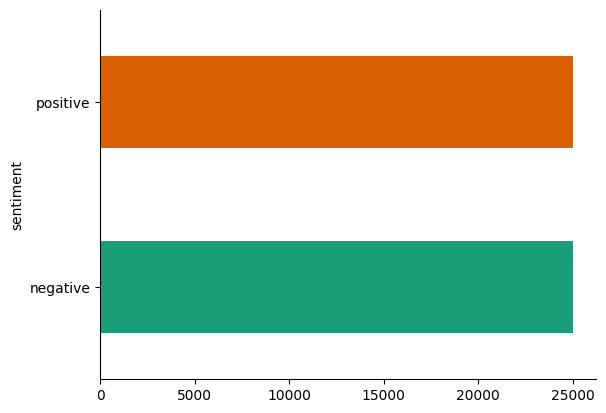

In [ ]:
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

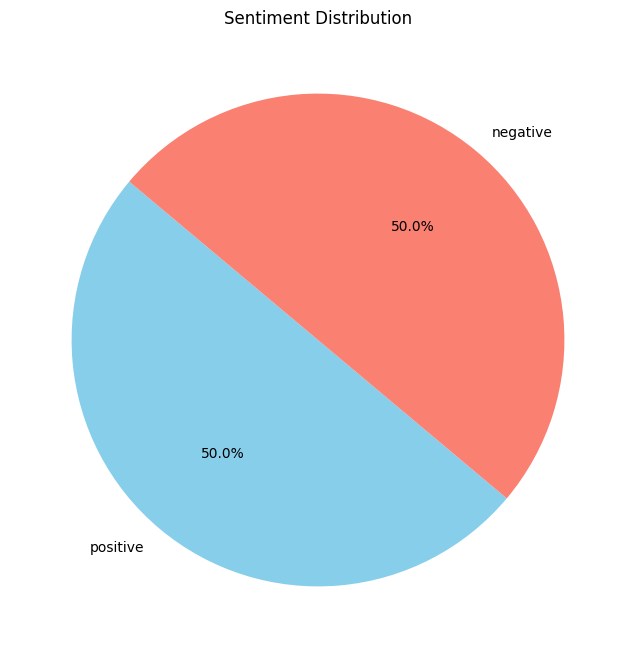

In [ ]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot a pie chart for the sentiment distribution
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    return " ".join(tokens)

In [ ]:
# Apply preprocessing to each review
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [ ]:
# Display the first few cleaned reviews
df[['review', 'cleaned_review', 'sentiment']].head()

,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...,positive
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,positive
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...,positive


In [ ]:
# Drop the first column by index
df = df.drop(df.columns[0], axis=1)

df = df[['cleaned_review', 'sentiment']]

# Save the DataFrame to a new CSV file without the first column
df.to_csv("IMDB_Dataset_Cleaned.csv", index=False)

In [ ]:
cleaned_df = pd.read_csv('/content/IMDB_Dataset_Cleaned.csv')

In [ ]:
cleaned_df.head()

,cleaned_review,sentiment
0,one reviewer mentioned watching oz episode you...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


In [ ]:
# Load pre-trained FastText embeddings (300 dimensions)
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

### 1. TF-IDF Feature Extraction ###
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Increase features
    ngram_range=(1, 2),  # Include unigrams and bigrams
)

# Fit and transform the cleaned review text into TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_df['cleaned_review'])

# Convert TF-IDF matrix to a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the shape of TF-IDF matrix
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

### 2. Word Embeddings using FastText ###
def get_average_fasttext(tokens, model, embedding_dim=300):
    # Filter words that are in the FastText model
    embeddings = [model[word] for word in tokens if word in model]

    # Calculate the average embedding
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Tokenize reviews if not already tokenized
if 'tokens' not in cleaned_df.columns:
    cleaned_df['tokens'] = cleaned_df['cleaned_review'].apply(word_tokenize)

# Calculate average FastText embeddings for each review
embedding_dim = 300  # FastText embeddings are 300-dimensional
cleaned_df['embedding'] = cleaned_df['tokens'].apply(lambda x: get_average_fasttext(x, fasttext_model, embedding_dim))

# Convert the embeddings column into a matrix (each embedding as a row in a 2D array)
embedding_matrix = np.vstack(cleaned_df['embedding'].values)

# Display the shape of Word Embedding matrix
print("Word Embedding Matrix shape:", embedding_matrix.shape)

TF-IDF Matrix shape: (50000, 10000)
Word Embedding Matrix shape: (50000, 300)


In [ ]:
# Save the sparse TF-IDF matrix
save_npz("TFIDF_Vectors.npz", tfidf_matrix)

In [ ]:
# Save to .npy format
np.save("Embedding_Vectors.npy", embedding_matrix)

In [ ]:
# Load TF-IDF vectors and labels
X_tfidf = load_npz("TFIDF_Vectors.npz")  # Use either TF-IDF or embedding matrix as features
X_embedding = np.load("Embedding_Vectors.npy")
y = cleaned_df['sentiment'].apply(lambda x: 1 if x == "positive" else 0).values

In [ ]:
# Convert Word2Vec embeddings to a sparse matrix to stack with TF-IDF
embedding_sparse_matrix = np.array(X_embedding)

# Combine TF-IDF and Word Embedding features
combined_features = np.hstack((X_tfidf.toarray(), embedding_sparse_matrix))

# Display the shape of the combined feature matrix
print("Combined Feature Matrix shape:", combined_features.shape)

Combined Feature Matrix shape: (50000, 10300)


In [ ]:
# Choose feature set and split the dataset
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, stratify=y, random_state=42)  # Or X_embedding

In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (40000, 10300)
X_test shape: (10000, 10300)
y_train shape: (40000,)
y_test shape: (10000,)


In [ ]:
# Initialize and train Logistic Regression model
log_reg = LogisticRegression(max_iter=500, C=2.0)
log_reg.fit(X_train, y_train)

LogisticRegression(C=2.0, max_iter=500)

In [ ]:
# Predictions and Evaluation
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8957
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



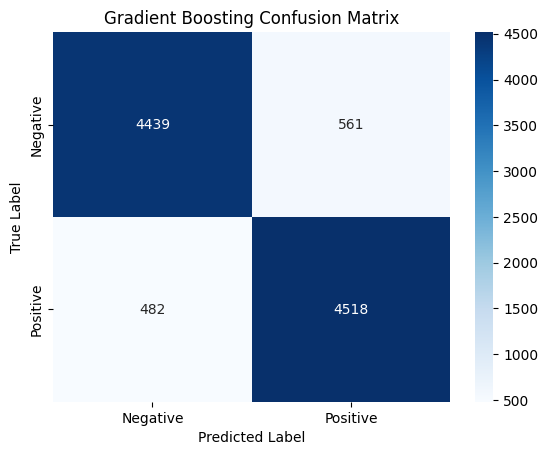

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

In [ ]:
# Save the model
joblib.dump(log_reg, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']